In [1]:
import torch
import torchvision
import torch.nn as nn 
from torch.nn import functional as F 
from VGG16_teacher import VGG

# Knowledge Distillation
## Teacher Network: VGG16  (pretrained on CIFAR 10 dataset)
## Student Network: 5 layer convolutional network (4 conv + 1 fc) 

In [2]:
random_seed = 1
torch.manual_seed(random_seed)

# Student Network

In [15]:
class five_layer_model(nn.Module):
    def __init__(self):
        super(five_layer_model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1, stride = 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1, stride = 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1, stride = 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1, stride = 1)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc = nn.Linear(256 * 4 * 4, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), inplace = True)     # 3 x 32 x 32  > 32 x 32 x 32
        x = F.max_pool2d(x, 2)                                  # 32 x 32 x 32 > 32 x 16 x 16
        x = F.relu(self.bn2(self.conv2(x)), inplace = True)     # 32 x 16 x 16 > 64 x 16 x 16
        x = F.max_pool2d(x, 2)                                  # 64 x 16 x 16 > 64 x 8 x 8
        x = F.relu(self.bn3(self.conv3(x)), inplace = True)     # 64 x 8 x 8   > 128 x 8 x 8
        x = F.max_pool2d(x, 2)                                  # 128 x 8 x 8  > 128 x 4 x 4
        x = F.relu(self.bn4(self.conv4(x)), inplace = True)     # 128 x 4 x 4  > 128 x 4 x 4
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Teacher Network: Load weight from saved file

In [30]:
student_model = five_layer_model()
student_model = student_model.cuda()

teacher_model = VGG('VGG16')
teacher_model = teacher_model.cuda()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [31]:
teacher_model.load_state_dict(torch.load('VGG16_teacher.pth'))

<All keys matched successfully>

# New Loss function 
## KL divergence + Cross entropy loss

In [18]:
def distillation(student_scores, true_labels, teacher_scores, T, alpha):
    return nn.KLDivLoss()(F.log_softmax(student_scores/T), F.softmax(teacher_scores/T)) * (T**2 *2.0 * alpha) + nn.CrossEntropyLoss()(student_scores, true_labels) * (1-alpha)

In [19]:
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
import time

In [20]:
optimizer = optim.SGD(student_model.parameters(), lr = 0.1, momentum = 0.9)
criterion = nn.CrossEntropyLoss()
step_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[30, 40], gamma =0.1)

In [21]:
def train(epoch):
    student_model.train()
    teacher_model.eval()
    running_loss = 0
    for batch_idx, data in enumerate(train_loader): 
        image, label = data
        image = image.cuda()
        labels = label.cuda()
        optimizer.zero_grad()

        student_output = student_model(image)
        teacher_output = teacher_model(image)
        teacher_output = teacher_output.detach()

        loss = distillation(student_output, labels, teacher_output, T = 2.0, alpha = 0.5)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 30 ==29:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * 128, len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(student_model.state_dict(), './distillation_model.pth')

In [22]:
def test(model, append = True):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += loss.item()
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss/(batch_idx+1), correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    if append:     
        test_losses.append(test_loss/(batch_idx+1))
        accuracy.append(100. * correct / len(test_loader.dataset))

In [23]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.RandomCrop(32, padding = 4),
                                 torchvision.transforms.RandomHorizontalFlip(),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                             ])),
  batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                             ])),
  batch_size=128, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


# Train 50 epochs

In [24]:
epochs = 50
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]
accuracy = []

In [25]:
test(teacher_model, append=False)


Test set: Avg. loss: 0.3717, Accuracy: 9043/10000 (90%)



In [26]:
test(student_model, append = True)
since = time.time()
for epoch in range(1, epochs + 1):
    train(epoch)
    test(student_model, append = True)
    test(teacher_model, append  = False)
    step_lr_scheduler.step()
finish = time.time()
print('Training Finished in {}min'.format((finish - since)//60))

n Epoch: 25 [19072/50000 (38%)]	Loss: 0.579398
Train Epoch: 25 [22912/50000 (46%)]	Loss: 0.583373
Train Epoch: 25 [26752/50000 (53%)]	Loss: 0.512217
Train Epoch: 25 [30592/50000 (61%)]	Loss: 0.472408
Train Epoch: 25 [34432/50000 (69%)]	Loss: 0.635106
Train Epoch: 25 [38272/50000 (76%)]	Loss: 0.525399
Train Epoch: 25 [42112/50000 (84%)]	Loss: 0.550921
Train Epoch: 25 [45952/50000 (92%)]	Loss: 0.452609
Train Epoch: 25 [49792/50000 (99%)]	Loss: 0.513387

Test set: Avg. loss: 0.8171, Accuracy: 7464/10000 (75%)


Test set: Avg. loss: 0.3602, Accuracy: 9043/10000 (90%)

Train Epoch: 26 [3712/50000 (7%)]	Loss: 0.652963
Train Epoch: 26 [7552/50000 (15%)]	Loss: 0.511927
Train Epoch: 26 [11392/50000 (23%)]	Loss: 0.582820
Train Epoch: 26 [15232/50000 (30%)]	Loss: 0.618526
Train Epoch: 26 [19072/50000 (38%)]	Loss: 0.556421
Train Epoch: 26 [22912/50000 (46%)]	Loss: 0.475259
Train Epoch: 26 [26752/50000 (53%)]	Loss: 0.573533
Train Epoch: 26 [30592/50000 (61%)]	Loss: 0.534204
Train Epoch: 26 [34432/5

# Plot Training Loss and Testing Loss 

[]

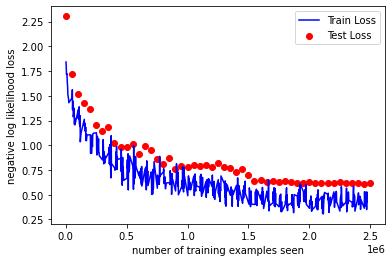

In [27]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.plot()

# Plot Test Accuracy 

[]

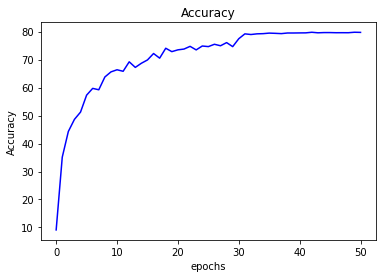

In [28]:
plt.figure()
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.plot(range(len(accuracy)), accuracy, color = 'blue')
plt.plot()

# Summary of the models 

In [29]:
from torchsummary import summary 

print('The number of parameters in Student model')
summary(student_model, (3, 32, 32))

print('The number of parameters in Teacher model')
summary(teacher_model, (3, 32, 32))

The number of parameters in Student model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 64, 16, 16]          18,496
       BatchNorm2d-4           [-1, 64, 16, 16]             128
            Conv2d-5            [-1, 128, 8, 8]          73,856
       BatchNorm2d-6            [-1, 128, 8, 8]             256
            Conv2d-7            [-1, 256, 4, 4]         295,168
       BatchNorm2d-8            [-1, 256, 4, 4]             512
            Linear-9                   [-1, 10]          40,970
Total params: 430,346
Trainable params: 430,346
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.94
Params size (MB): 1.64
Estimated Total Size (MB): 2.59
-